In [1]:
import sqlite3
import pandas as pd

In [9]:
conexion = sqlite3.connect("../data/eda.db")
cursor = conexion.cursor()

In [10]:
query = """
        CREATE TABLE IF NOT EXISTS Empleados (
            id INT PRIMARY KEY,
            nombre TEXT,
            genero TEXT,
            edad INT
        )
        """
conexion.execute(query)
conexion.commit()

In [11]:
add_query = """
            INSERT INTO Empleados (id, nombre, genero, edad) VALUES 
            (1, "José", "M", 34),
            (2, "Ester", "F", 28),
            (3, "Emily", "F", 24),
            (4, "David", "M", 44),
            (5, "Luis", "M", 54),
            (6, "Franco", "M", 38);
            """
conexion.execute(add_query)
conexion.commit()

#### Calcular Percentiles con SQLite

In [42]:
percentiles = """
                WITH ordenado AS (
                    SELECT edad, 
                    ROW_NUMBER() OVER (ORDER BY edad) AS fila,
                    COUNT(*) OVER () AS total_filas
                FROM empleados
                ),
                percentiles AS (
                    SELECT 
                        0.25 * (total_filas - 1) + 1 AS p25_pos,
                        0.50 * (total_filas - 1) + 1 AS p50_pos,
                        0.75 * (total_filas - 1) + 1 AS p75_pos
                    FROM ordenado
                    LIMIT 1
                )
                SELECT 
                    (SELECT edad FROM ordenado WHERE fila = FLOOR(p25_pos)) * (CEIL(p25_pos) - p25_pos) +
                    (SELECT edad FROM ordenado WHERE fila = CEIL(p25_pos)) * (p25_pos - FLOOR(p25_pos)) AS P25,

                    (SELECT edad FROM ordenado WHERE fila = FLOOR(p50_pos)) * (CEIL(p50_pos) - p50_pos) +
                    (SELECT edad FROM ordenado WHERE fila = CEIL(p50_pos)) * (p50_pos - FLOOR(p50_pos)) AS P50,

                    (SELECT edad FROM ordenado WHERE fila = FLOOR(p75_pos)) * (CEIL(p75_pos) - p75_pos) +
                    (SELECT edad FROM ordenado WHERE fila = CEIL(p75_pos)) * (p75_pos - FLOOR(p75_pos)) AS P75
                FROM percentiles;
                """
percentiles = pd.read_sql_query(percentiles, conexion)
percentiles

,P25,P50,P75
0,29.5,36.0,42.5


#### Calcular Percentiles con Pandas Python

In [24]:
# Obtener los datos de la tabla empleados
cursor.execute("SELECT edad FROM empleados")
edades = [fila[0] for fila in cursor.fetchall()]  # Convertir a lista

import numpy as np

p25 = np.percentile(edades, 25)
p50 = np.percentile(edades, 50)
p75 = np.percentile(edades, 75)

print(f"P25: {p25}, P50: {p50}, P75: {p75}")


P25: 29.5, P50: 36.0, P75: 42.5


#### Detectar valores Atípicos (Outliers) en SQLite

In [ ]:
quartilIQR = """
            WITH ordenado AS (
                SELECT edad, 
                    ROW_NUMBER() OVER (ORDER BY edad) AS fila,
                    COUNT(*) OVER () AS total
                FROM empleados
            ), percentiles AS (
                SELECT 
                    0.25 * (total - 1) + 1 AS p25_pos,
                    0.75 * (total - 1) + 1 AS p75_pos
                FROM ordenado 
                LIMIT 1
            ), valores AS (
                SELECT 
                    (SELECT edad FROM ordenado WHERE fila = FLOOR(p25_pos)) * (CEIL(p25_pos) - p25_pos) +
                    (SELECT edad FROM ordenado WHERE fila = CEIL(p25_pos)) * (p25_pos - FLOOR(p25_pos)) AS P25,
                    
                    (SELECT edad FROM ordenado WHERE fila = FLOOR(p75_pos)) * (CEIL(p75_pos) - p75_pos) +
                    (SELECT edad FROM ordenado WHERE fila = CEIL(p75_pos)) * (p75_pos - FLOOR(p75_pos)) AS P75
                FROM percentiles
            ), limites AS (
                SELECT 
                    P25, 
                    P75, 
                    (P75 - P25) AS IQR, 
                    (P25 - 1.5 * (P75 - P25)) AS Limite_Inferior, 
                    (P75 + 1.5 * (P75 - P25)) AS Limite_Superior
                FROM valores
            )
            SELECT e.edad 
            FROM empleados e
            JOIN limites l
            ON e.edad < l.Limite_Inferior OR e.edad > l.Limite_Superior;
            """
            
quartilIQR = pd.read_sql_query(quartilIQR, conexion)
print("Outliers encontrados: \n", quartilIQR)

Outliers encontrados: 
 Empty DataFrame
Columns: [edad]
Index: []


#### Detectar Outlier con Python Pandas

In [45]:
# Obtener los datos de la base de datos
cursor.execute("SELECT edad FROM empleados")
edades = [fila[0] for fila in cursor.fetchall()]  # Convertir a lista

# Crear DataFrame
df = pd.DataFrame(edades, columns=['edad'])

# Calcular P25, P75 e IQR
P25 = df['edad'].quantile(0.25, interpolation='linear')
P75 = df['edad'].quantile(0.75, interpolation='linear')
IQR = P75 - P25

# Definir límites de outliers
limite_inferior = P25 - 1.5 * IQR
limite_superior = P75 + 1.5 * IQR

# Filtrar outliers
outliers = df[(df['edad'] < limite_inferior) | (df['edad'] > limite_superior)]

# Mostrar resultados
print(f"P25: {P25}, P75: {P75}, IQR: {IQR}")
print(f"Límite inferior: {limite_inferior}, Límite superior: {limite_superior}")
print("Outliers detectados:")
print(outliers)

P25: 29.5, P75: 42.5, IQR: 13.0
Límite inferior: 10.0, Límite superior: 62.0
Outliers detectados:
Empty DataFrame
Columns: [edad]
Index: []


#### Distribuir Empleados en grupos según percentiles

In [51]:
distribuir_empleados = """
                        SELECT nombre, genero, edad,
                            NTILE(4) OVER (ORDER BY edad) AS cuartil
                        FROM empleados;
                       """
distribuir_empleados = pd.read_sql_query(distribuir_empleados, conexion)
distribuir_empleados

,nombre,genero,edad,cuartil
0,Emily,F,24,1
1,Ester,F,28,1
2,José,M,34,2
3,Franco,M,38,2
4,David,M,44,3
5,Luis,M,54,4


In [28]:
import sys
!{sys.executable} -m pip install openpyxl

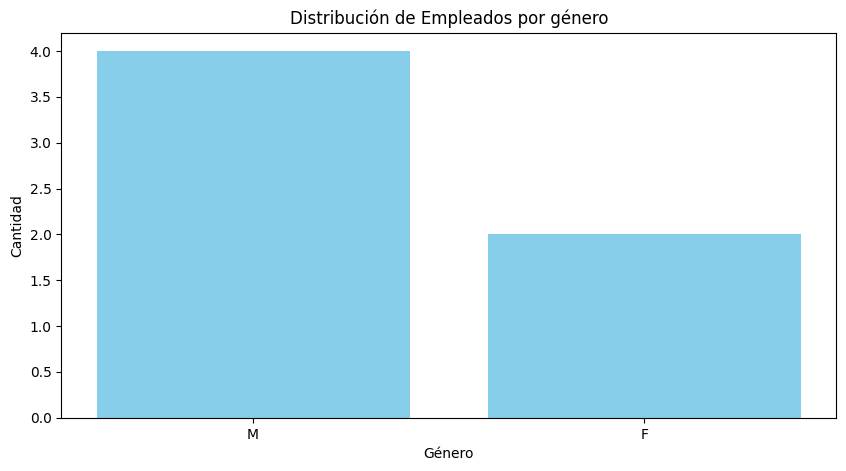

In [53]:

import matplotlib.pyplot as plt

query = """
SELECT genero, COUNT(*) AS cantidad
FROM Empleados
GROUP BY genero
ORDER BY cantidad DESC;
"""
df = pd.read_sql_query(query, conexion)

plt.figure(figsize=(10,5))
plt.bar(df['genero'], df['cantidad'], color='skyblue')
plt.xticks(rotation=None)
plt.xlabel("Género")
plt.ylabel("Cantidad")
plt.title("Distribución de Empleados por género")
plt.show()


In [29]:
df = "SELECT * FROM Empleados;"

df = pd.read_sql_query(df, conexion)

ruta_excel = "../data/Empleados.xlsx"
df.to_excel(ruta_excel, index=False, engine="openpyxl")

In [ ]:
#conexion.close()